In [1]:
import os
import polars as pl
from joblib import Parallel, delayed
import multiprocessing
import numpy as np
import pandas as pd
from tqdm import tqdm
import time
import json

In [2]:
test_df = pl.scan_csv('/home/dangnh36/datasets/competitions/leash_belka/processed/test_v4.csv').select(pl.col('*').exclude('molecule')).collect()
test_df

bb1,bb2,bb3,id_BRD4,id_HSA,id_sEH,mol_group,group_BRD4,group_HSA,group_sEH
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
1989,409,409,295246830,295246831,295246832,2,6,7,8
1989,409,1012,295246833,295246834,295246835,2,6,7,8
1989,409,1722,295246836,295246837,295246838,2,6,7,8
1989,409,1078,295246839,295246840,295246841,2,6,7,8
1989,409,605,295246842,295246843,295246844,2,6,7,8
…,…,…,…,…,…,…,…,…,…
141,1699,307,296921711,296921712,296921713,0,0,1,2
141,1699,1254,296921714,296921715,296921716,0,0,1,2
141,1415,1390,296921717,296921718,296921719,0,0,1,2


In [3]:
# 0: share, 1: new lib, 2 + 3: non-share
test_df.group_by('mol_group').count().sort('mol_group')

/tmp/ipykernel_29020/1203351766.py:2: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  test_df.group_by('mol_group').count().sort('mol_group')


mol_group,count
i64,u32
0,369039
1,486390
2,11271
3,11322


In [4]:
pred_ids = test_df[['id_BRD4', 'id_HSA', 'id_sEH']].to_numpy().reshape(-1)
group_ids = test_df[['group_BRD4', 'group_HSA', 'group_sEH']].to_numpy().reshape(-1)
mask = (pred_ids != 0)
assert(mask.sum()==1674896)
PRED_IDS = pred_ids[mask]
GROUP_IDS = group_ids[mask]
print(PRED_IDS.shape, GROUP_IDS.shape)

(1674896,) (1674896,)


In [5]:
np.unique(GROUP_IDS)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [6]:
os.listdir('/home/dangnh36/downloads/leash_submit/final')

['final_selfies-pregen_cnn1d-6-128',
 'final_smileschar-pregen_cnn1d-6-128',
 'catboost_12chunks',
 'final_squeeze-mtr_chartokenize-02_ep11_0.033802_0.651412',
 'final_sage',
 'topo_mlp',
 'ecfp6_mlp',
 'ensemble_v0.csv',
 'ensemble_v1.csv',
 'final_squeeze-mtr-mlm_chartokenize-02_ep11_0.11199_0.648898',
 'final_selfies-pregen_cnn1d-3-512',
 'ensemble_v2.csv',
 'final_ais-pregen_cnn1d-6-128',
 'mhfp_mlp',
 'final_smileschar-pregen_cnn1d-8-64',
 'final_pretrain-gin',
 'final_deepsmiles-pregen_cnn1d-6-128',
 'final_ais_squeeze',
 'final_gcn',
 'final_mamba_smileschar',
 'final_roberta-mtr-mlm_chartokenize-all_ep11.2_na_0.668808',
 'final_smileschar-pregen_cnn1d-3-512',
 'squeeze_first_version']

In [7]:
# SHARE_GROUPS= [0, 1, 2]
# NONSHARE_GROUPS = [3, 4, 5, 6, 7, 8, 9, 10, 11]

# # Share
# SHARE_META = [
#     ('catboost_12chunks', 0.5),
#     ('ecfp6_mlp', 0.5),
#     ('topo_mlp', 0.3),
#     # ('mhfp_mlp', 0.0),
#     ('final_smileschar-pregen_cnn1d-6-128', 1),
#     ('final_ais-pregen_cnn1d-6-128', 1),
#     ('final_selfies-pregen_cnn1d-6-128', 1),
#     ('final_deepsmiles-pregen_cnn1d-6-128', 1),
#     ('final_smileschar-pregen_cnn1d-8-64', 0.5),
#     ('final_smileschar-pregen_cnn1d-3-512', 1),
#     ('final_selfies-pregen_cnn1d-3-512', 1),
#     ('final_ais_squeeze', 1.5),
#     ('final_squeeze-mtr_chartokenize-02_ep11_0.033802_0.651412', 0.2),
#     ('final_squeeze-mtr-mlm_chartokenize-02_ep11_0.11199_0.648898', 0.2),
#     ('final_roberta-mtr-mlm_chartokenize-all_ep11.2_na_0.668808', 2.0),
#     ('final_mamba_smileschar', 2.0),
#     ('final_pretrain-gin', 0.5),
#     ('final_sage', 0.3),
#     ('final_gcn', 0.3)
# ]

# NONSHARE_META = [
#     ('catboost_12chunks', 1.5),
#     ('ecfp6_mlp', 1.0),
#     ('topo_mlp', 1.0),
#     ('mhfp_mlp', 1.0),
#     ('final_smileschar-pregen_cnn1d-6-128', 1),
#     ('final_ais-pregen_cnn1d-6-128', 1.5),
#     ('final_selfies-pregen_cnn1d-6-128', 1),
#     ('final_deepsmiles-pregen_cnn1d-6-128', 1),
#     ('final_smileschar-pregen_cnn1d-8-64', 1.5),
#     ('final_smileschar-pregen_cnn1d-3-512', 1),
#     ('final_selfies-pregen_cnn1d-3-512', 0.7),
#     ('final_ais_squeeze', 3.0),
#     ('final_squeeze-mtr_chartokenize-02_ep11_0.033802_0.651412', 2.0),
#     ('final_squeeze-mtr-mlm_chartokenize-02_ep11_0.11199_0.648898', 2.0),
#     ('final_roberta-mtr-mlm_chartokenize-all_ep11.2_na_0.668808', 3.0),
#     ('final_mamba_smileschar', 3.0),
#     ('final_pretrain-gin', 2.0),
#     ('final_sage', 0.75),
#     ('final_gcn', 0.75)
# ]

# len(SHARE_META), len(NONSHARE_META)

In [8]:
# SHARE_GROUPS= [0, 1, 2]
# NONSHARE_GROUPS = [3, 4, 5, 6, 7, 8, 9, 10, 11]

# # Share
# SHARE_META = [
#     ('catboost_12chunks', 0.2),
#     ('ecfp6_mlp', 0.2),
#     ('topo_mlp', 0.2),
#     # ('mhfp_mlp', 0.0),
#     ('final_smileschar-pregen_cnn1d-6-128', 1),
#     ('final_ais-pregen_cnn1d-6-128', 1),
#     ('final_selfies-pregen_cnn1d-6-128', 1),
#     ('final_deepsmiles-pregen_cnn1d-6-128', 1),
#     ('final_smileschar-pregen_cnn1d-8-64', 0.2),
#     ('final_smileschar-pregen_cnn1d-3-512', 0.5),
#     ('final_selfies-pregen_cnn1d-3-512', 0.5),
#     ('final_ais_squeeze', 1.5),
#     # ('final_squeeze-mtr_chartokenize-02_ep11_0.033802_0.651412', 0.2),
#     # ('final_squeeze-mtr-mlm_chartokenize-02_ep11_0.11199_0.648898', 0.2),
#     ('final_roberta-mtr-mlm_chartokenize-all_ep11.2_na_0.668808', 2.0),
#     ('final_mamba_smileschar', 2.0),
#     ('final_pretrain-gin', 0.2),
#     # ('final_sage', 0.2),
#     # ('final_gcn', 0.2)
# ]

# NONSHARE_META = [
#     ('catboost_12chunks', 0.5),
#     ('ecfp6_mlp', 0.2),
#     ('topo_mlp', 0.2),
#     ('mhfp_mlp', 0.2),
#     ('final_smileschar-pregen_cnn1d-6-128', 1),
#     ('final_ais-pregen_cnn1d-6-128', 1.5),
#     ('final_selfies-pregen_cnn1d-6-128', 0.5),
#     ('final_deepsmiles-pregen_cnn1d-6-128', 1),
#     ('final_smileschar-pregen_cnn1d-8-64', 1),
#     ('final_smileschar-pregen_cnn1d-3-512', 0.5),
#     ('final_selfies-pregen_cnn1d-3-512', 0.5),
#     ('final_ais_squeeze', 1.0),
#     ('final_squeeze-mtr_chartokenize-02_ep11_0.033802_0.651412', 1.0),
#     ('final_squeeze-mtr-mlm_chartokenize-02_ep11_0.11199_0.648898', 1.0),
#     ('final_roberta-mtr-mlm_chartokenize-all_ep11.2_na_0.668808', 2.0),
#     ('final_mamba_smileschar', 2.0),
#     ('final_pretrain-gin', 0.5),
#     ('final_sage', 0.2),
#     ('final_gcn', 0.2)
# ]

# len(SHARE_META), len(NONSHARE_META)

In [9]:
SHARE_GROUPS= [0, 1, 2]
NONSHARE_GROUPS = [3, 4, 5, 6, 7, 8, 9, 10, 11]

# Share
SHARE_META = [
    # ('catboost_12chunks', 0.2),
    # ('ecfp6_mlp', 0.2),
    # ('topo_mlp', 0.2),
    # ('mhfp_mlp', 0.0),
    ('final_smileschar-pregen_cnn1d-6-128', 1),
    ('final_ais-pregen_cnn1d-6-128', 1),
    ('final_selfies-pregen_cnn1d-6-128', 1),
    ('final_deepsmiles-pregen_cnn1d-6-128', 1),
    # ('final_smileschar-pregen_cnn1d-8-64', 0.2),
    # ('final_smileschar-pregen_cnn1d-3-512', 0.5),
    # ('final_selfies-pregen_cnn1d-3-512', 0.0),
    ('final_ais_squeeze', 1.0),
    # ('final_squeeze-mtr_chartokenize-02_ep11_0.033802_0.651412', 0.2),
    # ('final_squeeze-mtr-mlm_chartokenize-02_ep11_0.11199_0.648898', 0.2),
    ('final_roberta-mtr-mlm_chartokenize-all_ep11.2_na_0.668808', 1.0),
    ('final_mamba_smileschar', 1.0),
    # ('final_pretrain-gin', 0.2),
    # ('final_sage', 0.2),
    # ('final_gcn', 0.2)
]

NONSHARE_META = [
    # ('catboost_12chunks', 0.5),
    # ('ecfp6_mlp', 0.2),
    # ('topo_mlp', 0.2),
    # ('mhfp_mlp', 0.2),
    ('final_smileschar-pregen_cnn1d-6-128', 0.5),
    ('final_ais-pregen_cnn1d-6-128', 0.5),
    ('final_selfies-pregen_cnn1d-6-128', 0.5),
    ('final_deepsmiles-pregen_cnn1d-6-128', 0.5),
    ('final_smileschar-pregen_cnn1d-8-64', 0.2),
    ('final_smileschar-pregen_cnn1d-3-512', 0.2),
    ('final_selfies-pregen_cnn1d-3-512', 0.2),
    ('squeeze_first_version', 3.0),
    ('final_ais_squeeze', 1.0),
    ('final_squeeze-mtr_chartokenize-02_ep11_0.033802_0.651412', 0.8),
    ('final_squeeze-mtr-mlm_chartokenize-02_ep11_0.11199_0.648898', 0.8),
    ('final_roberta-mtr-mlm_chartokenize-all_ep11.2_na_0.668808', 1.0),
    ('final_mamba_smileschar', 1.0),
    ('final_pretrain-gin', 0.5),
    ('final_sage', 0.1),
    ('final_gcn', 0.1)
]

len(SHARE_META), len(NONSHARE_META)

(7, 16)

In [10]:
SUBMIT_DIR = '/home/dangnh36/downloads/leash_submit/final/'

ret_df = pd.DataFrame({
        'id': PRED_IDS,
        'group': GROUP_IDS,
        'binds': -1.0
})

for group in ['share', 'nonshare']:
    if group == 'share':
        meta = SHARE_META
        groups = SHARE_GROUPS
    elif group == 'nonshare':
        meta = NONSHARE_META
        groups = NONSHARE_GROUPS

    print(f'\n\n\nPROCESSING {group} with groups={groups}')

    preds_sum = 0
    weight_sum = 0
    for name, weight in meta:
        
        submit_dir = os.path.join(SUBMIT_DIR, name)
        sub_names = os.listdir(submit_dir)
        submit_all_name = [e for e in sub_names if e.endswith('_all.csv')]
        assert len(submit_all_name) == 1
        submit_all_name = submit_all_name[0]
        csv_path = os.path.join(submit_dir, submit_all_name)
        df = pl.scan_csv(csv_path).with_columns(group = GROUP_IDS).collect()
        preds = df.filter(pl.col('group').is_in(groups))['binds'].to_numpy()
        print(name, weight, preds.shape)
        preds_sum  = preds_sum + preds * weight
        weight_sum += weight

    group_preds = preds_sum / weight_sum
    assert group_preds.max() <= 1.0 and group_preds.min() >= 0.0
    ret_df.loc[ret_df['group'].isin(groups), 'binds'] = group_preds
    
ret_df




PROCESSING share with groups=[0, 1, 2]
final_smileschar-pregen_cnn1d-6-128 1 (1107117,)
final_ais-pregen_cnn1d-6-128 1 (1107117,)
final_selfies-pregen_cnn1d-6-128 1 (1107117,)
final_deepsmiles-pregen_cnn1d-6-128 1 (1107117,)
final_ais_squeeze 1.0 (1107117,)
final_roberta-mtr-mlm_chartokenize-all_ep11.2_na_0.668808 1.0 (1107117,)
final_mamba_smileschar 1.0 (1107117,)



PROCESSING nonshare with groups=[3, 4, 5, 6, 7, 8, 9, 10, 11]
final_smileschar-pregen_cnn1d-6-128 0.5 (567779,)
final_ais-pregen_cnn1d-6-128 0.5 (567779,)
final_selfies-pregen_cnn1d-6-128 0.5 (567779,)
final_deepsmiles-pregen_cnn1d-6-128 0.5 (567779,)
final_smileschar-pregen_cnn1d-8-64 0.2 (567779,)
final_smileschar-pregen_cnn1d-3-512 0.2 (567779,)
final_selfies-pregen_cnn1d-3-512 0.2 (567779,)
squeeze_first_version 3.0 (567779,)
final_ais_squeeze 1.0 (567779,)
final_squeeze-mtr_chartokenize-02_ep11_0.033802_0.651412 0.8 (567779,)
final_squeeze-mtr-mlm_chartokenize-02_ep11_0.11199_0.648898 0.8 (567779,)
final_roberta-

,id,group,binds
0,295246830,6,8.441086e-06
1,295246831,7,1.530732e-04
2,295246832,8,3.202490e-07
3,295246833,6,3.482661e-06
4,295246834,7,9.574712e-05
...,...,...,...
1674891,296921721,1,1.866019e-05
1674892,296921722,2,3.772606e-06
1674893,296921723,0,8.078780e-08
1674894,296921724,1,3.263110e-05


In [11]:
ret_df.binds.describe()

count    1.674896e+06
mean     4.231474e-03
std      4.857571e-02
min      1.822136e-18
25%      1.501110e-06
50%      2.374106e-05
75%      2.459138e-04
max      1.000000e+00
Name: binds, dtype: float64

<Axes: >

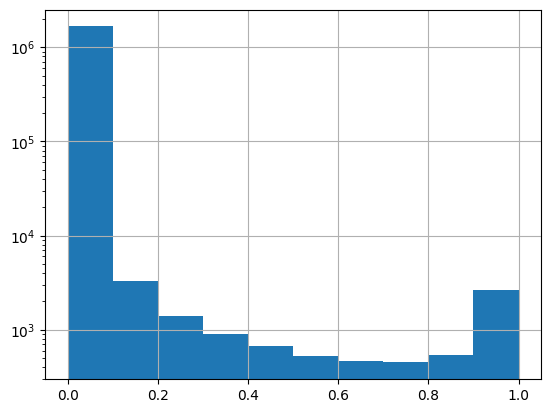

In [12]:
ret_df.binds.hist(log = True)

In [13]:
ret_df.binds.mean()

0.004231473880623705

In [14]:
ret_df

,id,group,binds
0,295246830,6,8.441086e-06
1,295246831,7,1.530732e-04
2,295246832,8,3.202490e-07
3,295246833,6,3.482661e-06
4,295246834,7,9.574712e-05
...,...,...,...
1674891,296921721,1,1.866019e-05
1674892,296921722,2,3.772606e-06
1674893,296921723,0,8.078780e-08
1674894,296921724,1,3.263110e-05


In [15]:
ret_df[['id', 'binds']].to_csv('/home/dangnh36/downloads/leash_submit/final/ensemble_v2.csv', index = False)